In [ ]:
# ================================================================================== #
# title           :Air_Levitation_PID_control.py                                     #
# description     :Script  PID Air Levitation control                                #
# author          :José Borges                                                       #
# date            :20220105                                                          #
# version         :0.1                                                               #
# @email jose.borges90@hotmail.com                                                   #
# python_version  :3.6                                                               #
# ================================================================================== #

# -*- coding: utf-8 -*-

from IPython import get_ipython
# from pythonping import ping
import requests
import time
import matplotlib.pyplot as plt


# Limpa o console e apaga todas as variáveis presentes:
try:
    get_ipython().magic('clear')
    # Apaga todas as variáveis:
    # get_ipython().magic('reset -f')
except:
    pass

global ESP
ESP = "http://192.168.0.150"

# FUNÇÕES
def teste_servidor():
    
    r = requests.get(ESP)

    print('Resposta do servidor:')
    print(r.status_code)
    print('\n')
    print('Conteúdo do servidor:')
    print(r.text)
    print('Resposta do body em bytes:')
    print(r.content)
    print('\n')
    print('Headers:')
    print(r.headers)
    
def pre_medicao(ligar):
    req_ligar = requests.get(ESP + ligar)
    
    print('Resposta do servidor:')
    print(req_ligar.status_code)
    print('\n')

def altura(medicao):
    # ping(ESP[7:], verbose=True)
    # print('\n')
    
    req_altura = requests.get(ESP + medicao)
    
    # if req_altura.text == 'nan':
    #     return alturas[-1]
    
    # print('Resposta do servidor:')
    # print(req_altura.status_code)
    # print('\n')
    
    # Conteúdo do servidor:
    # print(req_altura.text)
    return req_altura.text

def pos_medicao(desligar):
    req_desligar = requests.get(ESP + desligar)
    
    print('Resposta do servidor:')
    print(req_desligar.status_code)
    print('\n')
    
def set_pwm(pwm, valor_pwm):
    
    if float(valor_pwm) > 100:
        valor_pwm = "100"
    elif float(valor_pwm) < 0:
        valor_pwm = "0"
    
    pacote = {'PWM':valor_pwm}
    enviar_pwm = requests.get(ESP + pwm, params=pacote)
    print(enviar_pwm.url)
    
    
# ENDEREÇOS
ligar = '/Sensor/ON'
medicao = '/Sensor/Medicao'
desligar = '/Sensor/OFF'
pwm = '/Motor?'

# INICIO DO PROCESSO
# TESTE DE CONEXÃO
teste_servidor()

# TO DO:
    # DEFINIR MEIOS DE DETERMINAR O PERÍODO DE AMOSTRAGEM COM BASE
    # EM UMA MÉDIA DA TAXA DE TRANSFERÊNCIA DO SERVIDOR
    # ATUALMENTE: ENTRE 0.059s e 0.063s (59ms a 63ms) - SERVIDOR ASYNC

# IDEIAS
    # CRIAR UM ATRASO ADAPTATIVO PÓS AQUISIÇÃO DO DADO PARA AJUSTAR AO
    # TEMPO DE AMOSTRAGEM DESEJADO.
    
    # CRIAR UMA MEDIDA PROTETIVA PARA CASO O SERVIDOR DEMORE MAIS QUE O
    # TEMPO DE AMOSTRAGEM PARA ENVIAR O DADO, SEJA FEITA UMA LINEARIZAÇÃO
    # (PREDIÇÃO) COM BASE EM 2 OU MAIS DADOS ANTERIORES, PARA ESTIMAR O
    # DADO PERDIDO E DAR SEGUIMENTO AS MEDIÇÕES.
    
# PERGUNTAS:
    # UTILIZAR O ESP COMO "ACESS POINT", ONDE ESTE CRIA UMA REDE PRÓPRIA
    # E FAZER UMA CONEXÃO PC-ESP SEM O INTERMÉDIO DO ROTEADOR É
    # *CONSIDERAVELMENTE* MAIS VANTAJOSO QUE O ESP COMO WIFI-STATION?
    
# VARIÁVEIS:
Ts = 0.06
alturas = [] # VARIÁVEL DE SAÍDA (y)
controle = [0] # VARIÁVEL DE CONTROLE (u)
amostras = 500
# tempo = []
erro = [0,0]
rate = [0,0]

# x = []

a1 = -0.955255265000912
a2 = -0.029363939258160
b1 = 0.026243849901936
b2 = 0.274777441417530

# Controle
Kp = [0,0];
Kd = [0,0];
Ki = [0,0];

Kc = 0.04028;
Ti = 1.969;
Td = 0.49225;


# amostras = int(input("Defina a quantidade de amostras: "))
# valor_altura = input("Defina o valor de altura em milímetros: ")

patamar = 50
passo = 20
ref = []
for amostra in range(amostras):
    if amostra<=amostras/4:
        ref.append(patamar)
    if amostra>amostras/4:
        ref.append(patamar) 
    if amostra>amostras/2 and amostra<=3*amostras/4:
        ref.append(patamar + passo)
    if amostra>3*amostras/4:
        ref.append(patamar + passo)

#Senoidal

#for amostra in range(amostras):
 #   ref   = 50 + 20*np.sin(amostra*Ts)


valor_altura_float = [float(i) for i in ref]


# set_pwm(pwm, "80")
# time.sleep(1)

# MEDIÇÃO

# PREPARAÇÃO:
pre_medicao(ligar)
tempo_inicio_laco = time.time()
k=0;
# LAÇO DE AQUISIÇÃO:
for amostra in range(amostras):
    # plt.pause(0.01)
    tempo_inicio_amostra = time.time()
    alturas.append(int(altura(medicao)))
    print("--- %s seconds ---" % (time.time() - tempo_inicio_amostra))
    
 
    
    # MALHA FECHADA
    erro.append((valor_altura_float[k] - alturas[-1])/10)

   # Controlador:
    Ami = 1;
    Kp.append(Kc/Ami);
    Kd.append((Td)*Kc/Ami)
    Ki.append((Kc/Ami)/(Ti))

    alpha = (Kc/Ami)*(1+((Td)/Ts)+(Ts/(2*(Ti))));
    beta = -(Kc/Ami)*(1+2*((Td)/Ts)-(Ts/(2*(Ti))));
    gama = (Kc/Ami)*(Td)/Ts;

               
    u = controle[-1] + alpha*erro[-1] + beta*erro[-2] + gama*erro[-3];

    controle.append(u)
    
    # SATURAÇÃO 
    if controle[-1] > 80:
        controle[-1] = 80
    elif controle[-1] < 47:
        controle[-1] = 47

    set_pwm(pwm, controle[-1])
        
    # tempo.append(amostra*Ts)
    # time.sleep(Ts - (time.time() - tempo_inicio_amostra)) # Atraso adaptativo?
    
    # x.append(amostra)
    # plt.plot(x, alturas, 'r')
    # plt.title("Teste")
    k=k+1;
    
        
# PÓS AQUISIÇÃO
total = time.time() - tempo_inicio_laco
print("\n===============================================")
print("--- Total: %s seconds ---" % total)
print(f"--- Média: {total/amostras} segundos/amostra")
print("===============================================\n")
pos_medicao(desligar)

# set_pwm(pwm, "0")

# PLOTAGEM
plt.plot(list(range(amostras)), [valor_altura_float]*amostras, 'b')
plt.plot(list(range(amostras)), alturas, 'r')
# plt.plot(tempo, alturas)
plt.ylabel('Altura do objeto (mm)')
plt.xlabel('Número da amostra')
# plt.xlabel('Tempo')
plt.title("Altura desejada: " + str(valor_altura_float) + "mm")
plt.show()

plt.plot(list(range(amostras)), controle[:-1], 'g')
# plt.plot(tempo, alturas)
plt.ylabel('Variável de controle')
plt.xlabel('Número da amostra')
# plt.xlabel('Tempo')
plt.title("Controle - Altura desejada: " + str(valor_altura_float) + "mm")
plt.show()

In [13]:
Ts = 0.06
alturas = [] # VARIÁVEL DE SAÍDA (y)
controle = [0] # VARIÁVEL DE CONTROLE (u)
amostras = 500
# tempo = []
erro = [0,0]
rate = [0,0]

# x = []

a1 = -0.955255265000912
a2 = -0.029363939258160
b1 = 0.026243849901936
b2 = 0.274777441417530

# Controle
Kp = [0,0];
Kd = [0,0];
Ki = [0,0];

Kc = 0.04028;
Ti = 1.969;
Td = 0.49225;


# amostras = int(input("Defina a quantidade de amostras: "))
# valor_altura = input("Defina o valor de altura em milímetros: ")
patamar = 50
passo = 20
ref = []
for amostra in range(amostras):
    if amostra<=amostras/4:
        ref.append(patamar)
    if amostra>amostras/4:
        ref.append(patamar) 
    if amostra>amostras/2 and amostra<=3*amostras/4:
        ref.append(patamar + passo)
    if amostra>3*amostras/4:
        ref.append(patamar + passo)


valor_altura_float = [float(i) for i in ref]


In [2]:
t = [i for i in range(0,500)]

In [3]:

import math

lista = [50 + 20*math.sin(2*math.pi*1*i) for i in t]


In [4]:
import math
abs(-2)

lista = [ 2*math.pi*1*i for i in t]

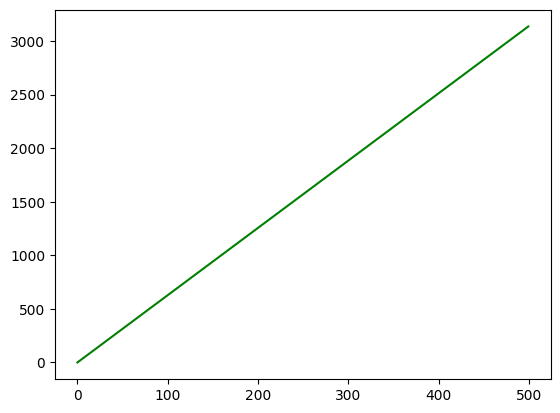

In [11]:
import matplotlib.pyplot as plt
plt.plot(lista, 'g')

In [10]:
math.pi

3.141592653589793

In [8]:
import numpy as np

import matplotlib.pyplot as plot

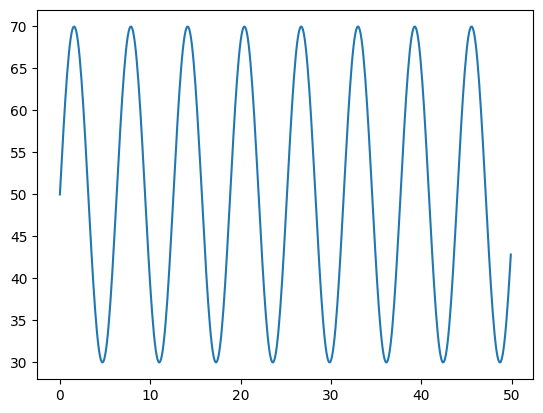

In [14]:
y=[]
time =[]
for amostra in range(amostras):
    #time        = np.arange(0, 10, 0.1);
    time.append(amostra*0.1) 
    amplitude   = 50 + 20*np.sin(time[-1])
    y.append(amplitude)
plot.plot(time, y)




In [11]:
import math 


def tri_mf_t1(x,param):
    
    a = param[1]
    b = param[2]
    c = param[3]
    
    y = max(min((x-a)/(b-a),(c-x)/(c-b)),0)
    
    return y


def Rshoulder_mf_t1(x,param):
    
    c = param[1];   
    d = param[2];

    y = max(min((1,(d-x)/(d-c))),0);
    
    return y


def Lshoulder_mf_t1(x,param):
    
    a = param[1];
    b = param[2];
    
    
    y = max(min(((x-a)/(b-a),1)),0);

    return y    

def gauss_mf_t1(x,param):
    
    rho = param[1];
    m = param[2];
    
    y = math.exp(-(1/2)*((x-m)/rho)**2)
    
    return y
    
    
def sigmoid_mf_t1(x,param):

    a = param[1];
    c = param[2];
    
    y = 1/(1 + math.exp(-a*(x-c)))   
    
    return y


In [ ]:
def inferencia_t1_3X3(pert_erro,pert_rate):
    
    
    R1 = pert_erro[1]*pert_rate[1]
    
    R2 =pert_erro[1]*pert_rate[2]
    
    R3= pert_erro[1]*pert_rate[3]
    
    R4 = pert_erro[2]*pert_rate[1]
    
    R5 =pert_erro[2]*pert_rate[2]
    
    R6= pert_erro[2]*pert_rate[3] 
    
    R7 = pert_erro[3]*pert_rate[1]
    
    R8 =pert_erro[3]*pert_rate[2]
    
    R9= pert_erro[3]*pert_rate[3]
    
    
    
    output = R1*(math.exp(-R1*4)) + R2*(math.exp(-R2*4)) + R3*(math.exp(-R3*4))+ R4*(1 - math.exp(-R4*4)) + R5*(1 - math.exp(-R5*4)) + R6*(1 - math.exp(-R6*4))+ R7*(math.exp(-R7*4)) + R8*(math.exp(-R8*4)) + R9*(math.exp(-R9*4));

    return output

In [8]:
def gain_margin_t1(erro,rate,L,param,Itype):
    
    if Itype == 'L':
        
        param_erro_N = param[1:2];
        param_erro_Z = param[3:5];
        param_erro_P = param[6:7];

        param_rate_N = param[8:9];
        param_rate_Z = param[10:12];
        param_rate_P = param[13:14];

        #Funções de pertinencia para o erro:
        erro_N = Rshoulder_mf_t1(erro,param_erro_N);
        erro_Z = tri_mf_t1(erro,param_erro_Z); 
        erro_P = Lshoulder_mf_t1(erro,param_erro_P);

        # Funções de pertinencia para o rate:
        rate_N = Rshoulder_mf_t1(erro,param_rate_N);
        rate_Z = tri_mf_t1(erro,param_rate_Z);
        rate_P = Lshoulder_mf_t1(erro,param_rate_P);

    elif Itype == 'N':

        param_erro_N = param[1:2];
        param_erro_Z = param[3:4];
        param_erro_P = param[5:6];

        param_rate_N = param[7:8];
        param_rate_Z = param[9:10];
        param_rate_P = param[11:12];

        %Funções de pertinencia para o erro:
        erro_N = 1-sigmoid_mf_t1(erro,param_erro_N);
        erro_Z = gauss_mf_t1(erro,param_erro_Z); 
        erro_P = sigmoid_mf_t1(erro,param_erro_P);

        % Funções de pertinencia para o rate:
        rate_N = 1-sigmoid_mf_t1(erro,param_rate_N);
        rate_Z = gauss_mf_t1(erro,param_rate_Z);
        rate_P = sigmoid_mf_t1(erro,param_rate_P);

    Am =  inferencia_t1_3X3([erro_N,erro_Z,erro_P],[rate_N,rate_Z,rate_P]);

    return Am               

In [6]:
L = 2
param =  [-L,0,-L,0,L,0,L,-L,0,-L,0,L,0,L]
FT1type = 'L';

In [5]:
erro = 0.16697;
rate = -0.00041075;



In [12]:
AA = gain_margin_t1(erro,rate,L,param,FT1type)

IndexError: list index out of range